In [1]:
%matplotlib inline
import numpy as n
import matplotlib.pyplot as p
import healpy as hp
pi=n.pi
import copy
import scipy.optimize as op
c=299792458

In [41]:
#take a cut through a beam
def hpCut(phi,nPix,data):
    nSide=hp.npix2nside(len(data))
    output=n.zeros(nPix)
    thetaVals=n.arange(nPix/2)/(nPix/2.)*pi/2.
    thetaVals=n.hstack([n.flipud(thetaVals),thetaVals,]).T
    phiVals=n.ones(len(thetaVals))
    phi1=phi+pi
    phiVals[:nPix/2]=phi1
    phiVals[nPix/2:]=phi
    output=hp.get_interp_val(data,thetaVals,phiVals)
    return output


#rotate
def rotateBeam(inputMap,rot=[90,0,0]):
    rotator=hp.Rotator(rot=rot)
    npix=len(inputMap)
    nside=hp.npix2nside(npix)
    theta,phi=hp.pix2ang(nside,range(npix))
    newtheta,newphi=rotator(theta,phi)
    output=hp.get_interp_val(inputMap,newtheta,newphi)
    return output
    


class Beam:
    def __init__(self,nside=64,pols=['XX','YY'],rotateY=False,invert=False):
        self.nside=nside
        self.npolsOriginal=len(pols)
        self.npols=max(len(pols),2)
        self.nPix=hp.nside2npix(nside)
        self.nSide=nside
        self.invert=invert
        self.pixArea=hp.nside2pixarea(self.nSide)
        self.pols=pols
        if(rotateY):
            pols.append('YY')
            
    def _interp_beam(self,beam_file,pol,chan):
        data=n.loadtxt(beam_file,skiprows=2);
        theta,phi=hp.pix2ang(self.nSide,range(self.nPix))
        theta=n.round(n.degrees(theta)).astype(int)
        phi=n.round(n.degrees(phi)).astype(int)
        self.data[pol,chan,:]=10**((data[:,2].squeeze().reshape(360,181))[phi,theta]/10.)
        self.data[pol,chan,:]/=self.data[pol,chan,:].flatten().max();    
        if(self.invert):
            self.data[pol,chan,:]=rotateBeam(self.data[pol,chan,:].flatten(),rot=[0,180,0])
        self.data[pol,chan,theta>90.]=0.
        self.solidAngles[pol,chan]=self.pixArea*n.sum(self.data[pol,chan,:])
        self.effArea[pol,chan]=(c/(self.fAxis[chan]))**2./self.solidAngles[pol,chan]
        if(self.npolsOriginal==1):
            self.data[1,chan,:]=rotateBeam(self.data[0,chan,:].flatten())
            self.solidAngles[1,chan]=self.pixArea*n.sum(self.data[1,chan,:])
            self.effArea[1,chan]=(c/(self.fAxis[chan]))**2./(self.solidAngles[1,chan])
        if(len(self.pols)>1 and self.pols[0]=='XX' and self.pols[1]=='YY'):
            self.ellipticity[chan]=n.sum((self.data[0,chan]-self.data[1,chan])**2.)/n.sum((self.data[0,chan]+self.data[1,chan])**2.)
    def read_files(self,flist,filelist):
        self.nf=len(flist)
        self.fAxis=n.zeros(self.nf)
        self.data=n.zeros((self.npols,self.nf,self.nPix))   
        self.solidAngles=n.zeros((self.npols,self.nf))
        self.effArea=n.zeros_like(self.solidAngles)
        self.ellipticity=n.zeros(self.nf)

        for m in range(self.nf):
            tempf=flist[m].split('p')
            self.fAxis[m]=float(tempf[0])*1e6
            for p in range(self.npolsOriginal):
                self._interp_beam(filelist[p*self.nf+m],p,m)
                
                
class FeedData:
    def __init__(self,fListFeedOnly,fListFeedOverDish,
                 freqList,nside,
                 pols=['XX','YY'],rotateY=False,
                 invertFeedOnly=True,
                 invertDish=True,
                 dDish=14.,dFocus=4.5):
        self.nf=len(freqList)
        self.nSide=nside
        self.nPix=hp.nside2npix(nside)
        self.daveFeedEfficiency=n.zeros(self.nf)
        self.daveTaper=n.zeros(self.nf)
        self.davePol=n.zeros(self.nf)
        self.daveBeamEfficiency=n.zeros(self.nf)
        self.dDish=dDish
        self.dFocus=dFocus
        self.thetaEdge=2.*n.arctan(self.dDish/(4.*self.dFocus))
        self.beamFeedAndDish=Beam(nside,copy.deepcopy(pols),rotateY,invertDish)
        self.beamFeedAndDish.read_files(freqList,fListFeedOverDish)
        self.beamFeedOnly=Beam(nside,pols,rotateY,invertFeedOnly)
        print fListFeedOnly
        self.beamFeedOnly.read_files(freqList,fListFeedOnly)
        self.fAxis=self.beamFeedOnly.fAxis
        self.beamFWHM=n.zeros(len(self.fAxis))
        self.gain=4.*pi/self.beamFeedAndDish.solidAngles[0,:]
        theta,phi=hp.pix2ang(self.nSide,range(self.nPix))


        self.nSide=nside
        self.nPix=hp.nside2npix(self.nSide)
        self.pols=self.beamFeedAndDish.pols
        for mm in range(self.nf):
            dataFeed=self.beamFeedOnly.data[0,mm,:]
            dataDish=self.beamFeedAndDish.data[0,mm,:]
            #compute feed efficiency by integrating feed beam intercepted by dish
            selectionEdge=theta<self.thetaEdge
            self.daveFeedEfficiency[mm]=n.sum(dataFeed[selectionEdge])/n.sum(dataFeed)
            #compute taper by averaging gain on ring at dish edge
            phiRange=n.radians(n.arange(0,360))
            thetaRange=n.ones(len(phiRange))*self.thetaEdge
            self.daveTaper[mm]=1./n.mean(hp.get_interp_val(dataFeed,thetaRange,phiRange))
            #compute polarization mismatch by integrating phi=0 and phi=90
            thetaRange=n.radians(n.arange(0,180))
            phiRange=n.ones(len(thetaRange))*0.
            xArc=hp.get_interp_val(dataDish,thetaRange,phiRange)
            yArc=hp.get_interp_val(dataDish,thetaRange,phiRange+pi/2.)
            self.davePol[mm]=n.sum((n.sqrt(xArc)-n.sqrt(yArc))**2.)/n.sum((n.sqrt(xArc)+n.sqrt(yArc))**2.)
            #compute beam efficiency. First determine FWHM by taking average in 360 degree ring. 
            stddevs=[]
            nth=1000
            tha=n.arange(-nth/2,nth/2)*pi/nth
            for nn in range(0,180,10):
                cut=hpCut(n.radians(nn),nth,dataDish)
                try:
                    stddevs.append(op.curve_fit(lambda x,p: n.exp(-x**2./(2.*p**2.)),tha,cut,p0=[n.radians(15.)])[0])
                except Exception as e:
                    print e
                    print 'error'
                    p.plot(tha,cut)
                    p.yscale('log')
                    p.show()
            stddeves=n.array(stddevs)
            stddev=n.max(stddevs)
            fwhm=2.*n.sqrt(2.*n.log(2.))*stddev
            print n.degrees(fwhm)
            self.beamFWHM[mm]=fwhm
            selectionFWHM=theta<fwhm/2.
            self.daveBeamEfficiency[mm]=n.sum(dataDish[selectionFWHM])/n.sum(dataDish)

In [47]:
#beamCylinder=Beam('beamCylinder',['100'],64)
fstrList=['050','060','070','080','090','100','110','120','130','140','150']
fstrListHigh=['100','110','120','130','140','150','160','170','180','190','200']


fListHighBandFeedOverDish=['../data/beams/beamSouthAfricaFeedOverDish/farfield (f=%s) [1].txt'%(m) for m in fstrListHigh]
fListHighBand=['../data/beams/beamSouthAfricaFeedOnly/farfield (f=%s) [1].txt'%(m) for m in fstrListHigh]
print fListHighBand
FeedHighBand=FeedData(fListFeedOnly=fListHighBand,
                      fListFeedOverDish=fListHighBandFeedOverDish,
                      freqList=fstrListHigh,
                      nside=64,
                      pols=['XX'],rotateY=True,invertFeedOnly=False)
#FeedPickets=FeedData('beamPaneledCylinder','beamPicketCylinderFeedOnly_v2',fstrList,64,['XX'],rotateY=True)
#FeedCylinder=FeedData('beamCylinderBackPlane_v2','beamCylinderFeedOnly_v2',fstrList,64,['XX'],rotateY=True)
#FeedBackPlane=FeedData('beamBackPlane_v2','beamBackPlaneFeedOnly_v2',fstrList,64,['XX'],rotateY=True)
#FeedCylinderAdaptive=FeedData('beamCylinderBackPlaneAdaptive_v2','beamCylinderFeedOnly_v2',fstrList,64,['XX'],rotateY=True)
#FeedCylinderShortNoGap=FeedData('beamCylinderBackPlaneShortNoGap_v2','beamCylinderBackPlaneShortNoGapFeedOnly_v2',fstrList,64,['XX'],rotateY=True)
#FeedCylinderShortGap=FeedData('beamCylinderBackPlaneShortGap_v2','beamCylinderBackPlaneShortGapFeedOnly',fstrList,64,['XX'],rotateY=True)
#FeedCylinderNoGap=FeedData('beamCylinderBackPlaneNoGap_v2','beamCylinderBackPlaneNoGapFeedOnly_v2',fstrList,64,['XX'],rotateY=True)

#FeedCTP=FeedData('beamCTPFeedOverDish','beamCTPFeedOnly',fstrList,64,['XX'],rotateY=True,invertFeedOnly=False,invertDish=True)
#FeedCTPShort=FeedData('beamCTPShortFeedOverDish','beamCTPShortFeedOnly',fstrList,64,['XX'],rotateY=True,invertFeedOnly=False,invertDish=True)
#FeedCTPShortNoGap=FeedData('beamCTPShortNoGapFeedOverDish','beamCTPShortNoGapFeedOnly',fstrList,64,['XX'],rotateY=True,invertFeedOnly=False,invertDish=True)


['../data/beams/beamSouthAfricaFeedOnly/farfield (f=100) [1].txt', '../data/beams/beamSouthAfricaFeedOnly/farfield (f=110) [1].txt', '../data/beams/beamSouthAfricaFeedOnly/farfield (f=120) [1].txt', '../data/beams/beamSouthAfricaFeedOnly/farfield (f=130) [1].txt', '../data/beams/beamSouthAfricaFeedOnly/farfield (f=140) [1].txt', '../data/beams/beamSouthAfricaFeedOnly/farfield (f=150) [1].txt', '../data/beams/beamSouthAfricaFeedOnly/farfield (f=160) [1].txt', '../data/beams/beamSouthAfricaFeedOnly/farfield (f=170) [1].txt', '../data/beams/beamSouthAfricaFeedOnly/farfield (f=180) [1].txt', '../data/beams/beamSouthAfricaFeedOnly/farfield (f=190) [1].txt', '../data/beams/beamSouthAfricaFeedOnly/farfield (f=200) [1].txt']
['../data/beams/beamSouthAfricaFeedOnly/farfield (f=100) [1].txt', '../data/beams/beamSouthAfricaFeedOnly/farfield (f=110) [1].txt', '../data/beams/beamSouthAfricaFeedOnly/farfield (f=120) [1].txt', '../data/beams/beamSouthAfricaFeedOnly/farfield (f=130) [1].txt', '../data

In [48]:
print FeedHighBand.beamFeedAndDish.data.shape

(2, 11, 49152)


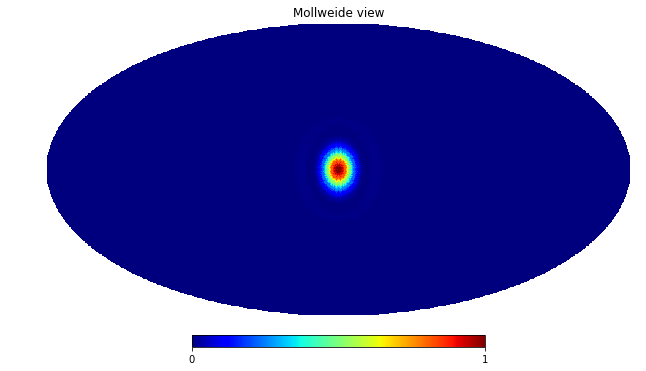

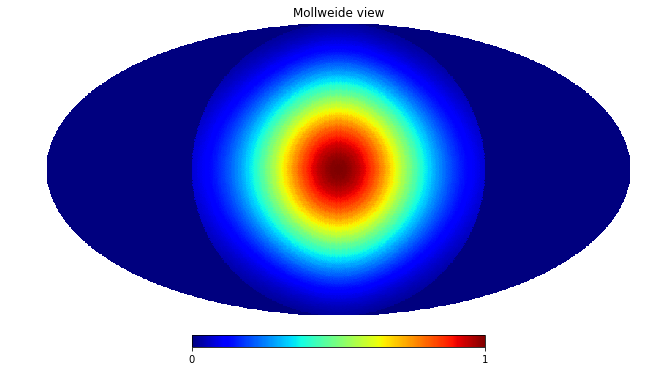

In [49]:
hp.mollview(FeedHighBand.beamFeedAndDish.data[0,0,:],rot=(0,90,0))
hp.mollview(FeedHighBand.beamFeedOnly.data[0,0,:],rot=(0,90,0))

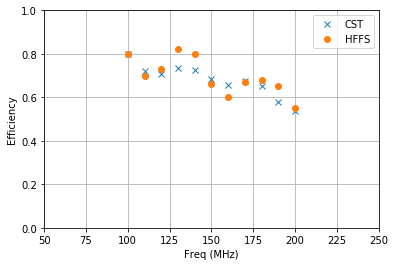

In [62]:
daveEff=n.array([.8,.7,.73,.82,.8,.66,.6,.67,.68,.65,.55])
p.plot(FeedHighBand.fAxis/1e6,FeedHighBand.beamFeedAndDish.effArea[0]/(n.pi*7**2.),ls='None',marker='x',label='CST')
p.plot(FeedHighBand.fAxis/1e6,daveEff,ls='None',marker='o',label='HFFS')
n.savetxt('highBandEfficiency_SouthAfrica.txt',
           n.vstack([FeedHighBand.fAxis/1e6,
           FeedHighBand.beamFeedAndDish.effArea[0]/(n.pi*7**2.),
           daveEff]).T)
p.xlim(50,250)
p.ylim(0,1)
p.grid()
p.xlabel('Freq (MHz)')
p.ylabel('Efficiency')
p.legend(loc='best')
p.savefig('hffs_cst_efficiency_comparison.pdf')


In [ ]:
#print FeedPickets.daveBeamEfficiency.shape
p.plot(FeedCTP.fAxis/1e6,10.*n.log10(FeedCTP.gain),label='CTP',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.gain),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.gain),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCTPShort.fAxis/1e6,10.*n.log10(FeedCTPShort.gain),label='CTP Short',color='r',ls='-',lw=2)
p.plot(FeedCTPShortNoGap.fAxis/1e6,10.*n.log10(FeedCTPShortNoGap.gain),label='CTP Short No Gap',color='grey',ls='-',lw=2)


#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedBackPlane.gain),label='Feed with Backplane only',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Directivity (dB)',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/Directivity_CTP_Only.pdf',bbox_inches='tight')

In [ ]:
#print FeedPickets.daveBeamEfficiency.shape
p.plot(FeedCylinder.fAxis/1e6,10.*n.log10(FeedCylinder.gain),label='Cylinder Feed',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.gain),label='Picket Feed',color='grey',ls='-',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.gain),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCTP.fAxis/1e6,10.*n.log10(FeedCTP.gain),label='CTP',color='r',ls='-',lw=2)


#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedBackPlane.gain),label='Feed with Backplane only',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Directivity (dB)',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.savefig('../analysis/Directivity.pdf',bbox_inches='tight')

In [ ]:
#print FeedPickets.daveBeamEfficiency.shape
p.plot(FeedCylinder.fAxis/1e6,10.*n.log10(FeedCylinder.gain),label='Cylinder Feed',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.gain),label='Picket Feed',color='grey',ls='-',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.gain),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.gain),label='Short Cylinder Feed\n No Gap',color='r',ls='-',lw=2)


#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedBackPlane.gain),label='Feed with Backplane only',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Directivity (dB)',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.savefig('../analysis/Directivity.pdf',bbox_inches='tight')

In [ ]:
print FeedPickets.daveBeamEfficiency.shape
l0=p.plot(FeedCylinder.fAxis/1e6,10.*n.log10(FeedCylinder.gain),label='Cylinder Feed',color='k',lw=2,ls='-')[0]
p.plot(FeedCylinderNoGap.fAxis/1e6,10.*n.log10(FeedCylinderNoGap.gain),color='k',ls='--',lw=2)
#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.gain),label='Picket Feed',color='grey',ls='-',lw=2)
l1=p.plot(FeedCylinderShortGap.fAxis/1e6,10.*n.log10(FeedCylinderShortGap.gain),color='r',lw=2,ls='-')[0]
p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.gain),label='Short Cylinder Feed\n No Gap',color='r',ls='--',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.gain),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
#p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.gain),label='Cylinder Feed',color='r',ls='-',lw=2)


#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedBackPlane.gain),label='Feed with Backplane only',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Directivity (dB)',fontsize=20)
p.gca().legend((l0,l1),('Tall Feed','Short Feed'),loc='best',fontsize=10,ncol=2)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/DirectivityCompareGap.pdf',bbox_inches='tight')

In [ ]:
print FeedPickets.daveBeamEfficiency.shape
p.plot(FeedCylinder.fAxis/1e6,10.*n.log10(FeedCylinder.gain),label='Cylinder Feed',color='k',ls='-',lw=2)
p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.gain),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.gain),label='Short Cylinder Feed\n No Gap',color='r',ls='-',lw=2)
p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.gain),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
#p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.gain),label='Cylinder Feed',color='r',ls='-',lw=2)


#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedBackPlane.gain),label='Feed with Backplane only',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Directivity (dB)',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=2)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/Directivity.pdf',bbox_inches='tight')

In [ ]:
print FeedCTP.daveBeamEfficiency



In [ ]:

p.plot(FeedCTP.fAxis/1e6,(FeedCTP.daveBeamEfficiency),label='CTP',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,(FeedPickets.daveBeamEfficiency),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.daveBeamEfficiency),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCTPShort.fAxis/1e6,(FeedCTPShort.daveBeamEfficiency),label='CTP Short',color='r',ls='-',lw=2)

p.plot(FeedCTPShortNoGap.fAxis/1e6,(FeedCTPShortNoGap.daveBeamEfficiency),label='CTP Short\n No Gap',color='grey',ls='-',lw=2)


#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Main-lobe efficiency: $\\epsilon_b$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/Efficiency_CTP_Only.pdf',bbox_inches='tight')

In [ ]:

p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.daveBeamEfficiency),label='Cylinder Feed',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,(FeedPickets.daveBeamEfficiency),label='Picket Feed',color='grey',ls='-',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.daveBeamEfficiency),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCTP.fAxis/1e6,(FeedCTP.daveBeamEfficiency),label='CTP',color='r',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Main-lobe efficiency: $\\epsilon_b$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.savefig('../analysis/Efficiency.pdf',bbox_inches='tight')

In [ ]:
print FeedPickets.daveBeamEfficiency.shape

p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.daveBeamEfficiency),label='Cylinder Feed',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,(FeedPickets.daveBeamEfficiency),label='Picket Feed',color='grey',ls='-',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.daveBeamEfficiency),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCylinderShortNoGap.fAxis/1e6,(FeedCylinderShortNoGap.daveBeamEfficiency),label='Short Cylinder Feed\n No Gap',color='r',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Main-lobe efficiency: $\\epsilon_b$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.savefig('../analysis/Efficiency.pdf',bbox_inches='tight')

In [ ]:
print FeedPickets.daveBeamEfficiency.shape
l0=p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.daveBeamEfficiency),label='Cylinder Feed',color='k',lw=2,ls='-')[0]
p.plot(FeedCylinderNoGap.fAxis/1e6,(FeedCylinderNoGap.daveBeamEfficiency),color='k',ls='--',lw=2)
#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.gain),label='Picket Feed',color='grey',ls='-',lw=2)
l1=p.plot(FeedCylinderShortGap.fAxis/1e6,(FeedCylinderShortGap.daveBeamEfficiency),color='r',lw=2,ls='-')[0]
p.plot(FeedCylinderShortNoGap.fAxis/1e6,(FeedCylinderShortNoGap.daveBeamEfficiency),label='Short Cylinder Feed\n No Gap',color='r',ls='--',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.gain),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
#p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.gain),label='Cylinder Feed',color='r',ls='-',lw=2)


#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedBackPlane.gain),label='Feed with Backplane only',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Main Lobe Efficiency, $\\epsilon_b$',fontsize=20)
p.gca().legend((l0,l1),('Tall Feed','Short Feed'),loc='best',fontsize=10,ncol=2)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/EfficiencyCompareGap.pdf',bbox_inches='tight')

In [ ]:
print FeedPickets.daveBeamEfficiency.shape

p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.daveBeamEfficiency),label='Cylinder Feed',color='k',ls='-',lw=2)
p.plot(FeedPickets.fAxis/1e6,(FeedPickets.daveBeamEfficiency),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedCylinderShortNoGap.fAxis/1e6,(FeedCylinderShortNoGap.daveBeamEfficiency),label='Short Cylinder Feed\n No Gap',color='r',ls='-',lw=2)

p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.daveBeamEfficiency),label='High Band (100-200MHz)',color='k',ls='--',lw=2)


#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Main-lobe efficiency: $\\epsilon_b$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=2)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/Efficiency.pdf',bbox_inches='tight')

In [ ]:
#print FeedPickets.daveBeamEfficiency.shape
p.plot(FeedCTP.fAxis/1e6,(FeedCTP.daveFeedEfficiency),label='CTP',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.gain),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.daveFeedEfficiency),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCTPShort.fAxis/1e6,(FeedCTPShort.daveFeedEfficiency),label='CTP Short',color='r',ls='-',lw=2)
p.plot(FeedCTPShortNoGap.fAxis/1e6,(FeedCTPShortNoGap.daveFeedEfficiency),label='CTP Short No Gap',color='grey',ls='-',lw=2)


#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedBackPlane.gain),label='Feed with Backplane only',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Feed Efficiency, $\\epsilon_f$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/feedEfficiency_CTP_Only.pdf',bbox_inches='tight')

In [ ]:
#print FeedPickets.daveFeedEfficiency.shape
p.plot(FeedCTP.fAxis/1e6,FeedCTP.daveFeedEfficiency,label='CTP',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,FeedPickets.daveFeedEfficiency,label='Picket Feed',color='grey',ls='-',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.daveFeedEfficiency),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCTPShort.fAxis/1e6,(FeedCTPShort.daveFeedEfficiency),label='CTP Short',color='r',ls='-',lw=2)
p.plot(FeedCTPShortNoGap.fAxis/1e6,(FeedCTPShortNoGap.daveFeedEfficiency),label='CTP Short No Gap',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Feed Efficiency: $\\epsilon_f$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.savefig('../analysis/feedEfficiency.pdf',bbox_inches='tight')

In [ ]:
#print FeedPickets.daveFeedEfficiency.shape
p.plot(FeedCylinder.fAxis/1e6,FeedCylinder.daveFeedEfficiency,label='Cylinder Feed',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,FeedPickets.daveFeedEfficiency,label='Picket Feed',color='grey',ls='-',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.daveFeedEfficiency),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCTP.fAxis/1e6,(FeedCTP.daveFeedEfficiency),label='CTP',color='r',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Feed Efficiency: $\\epsilon_f$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.savefig('../analysis/feedEfficiency.pdf',bbox_inches='tight')

In [ ]:
#print FeedPickets.daveFeedEfficiency.shape
p.plot(FeedCylinder.fAxis/1e6,FeedCylinder.daveFeedEfficiency,label='Cylinder Feed',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,FeedPickets.daveFeedEfficiency,label='Picket Feed',color='grey',ls='-',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.daveFeedEfficiency),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCylinderShortNoGap.fAxis/1e6,(FeedCylinderShortNoGap.daveFeedEfficiency),label='Short Cylinder Feed\n No Gap',color='r',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Feed Efficiency: $\\epsilon_f$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.savefig('../analysis/feedEfficiency.pdf',bbox_inches='tight')

In [ ]:
print FeedPickets.daveBeamEfficiency.shape
l0=p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.daveFeedEfficiency),label='Cylinder Feed',color='k',lw=2,ls='-')[0]
p.plot(FeedCylinderNoGap.fAxis/1e6,(FeedCylinderNoGap.daveFeedEfficiency),color='k',ls='--',lw=2)
#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.gain),label='Picket Feed',color='grey',ls='-',lw=2)
l1=p.plot(FeedCylinderShortGap.fAxis/1e6,(FeedCylinderShortGap.daveFeedEfficiency),color='r',lw=2,ls='-')[0]
p.plot(FeedCylinderShortNoGap.fAxis/1e6,(FeedCylinderShortNoGap.daveFeedEfficiency),label='Short Cylinder Feed\n No Gap',color='r',ls='--',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.gain),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
#p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.gain),label='Cylinder Feed',color='r',ls='-',lw=2)


#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedBackPlane.gain),label='Feed with Backplane only',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Feed Efficiency,$\\epsilon_f$',fontsize=20)
p.gca().legend((l0,l1),('Tall Feed','Short Feed'),loc='best',fontsize=10,ncol=2)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/feedEfficiencyCompareGap.pdf',bbox_inches='tight')

In [ ]:
print FeedPickets.daveFeedEfficiency.shape
p.plot(FeedCylinder.fAxis/1e6,FeedCylinder.daveFeedEfficiency,label='Cylinder Feed',color='k',ls='-',lw=2)
p.plot(FeedPickets.fAxis/1e6,FeedPickets.daveFeedEfficiency,label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedCylinderShortNoGap.fAxis/1e6,(FeedCylinderShortNoGap.daveFeedEfficiency),label='Short Cylinder Feed\n No Gap',color='r',ls='-',lw=2)
p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.daveFeedEfficiency),label='High Band (100-200MHz)',color='k',ls='--',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Feed Efficiency: $\\epsilon_f$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=2)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/feedEfficiency.pdf',bbox_inches='tight')

In [ ]:
p.plot(FeedCTP.fAxis/1e6,10.*n.log10(FeedCTP.daveTaper),label='CTP',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.daveTaper),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.daveTaper),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCTPShort.fAxis/1e6,10.*n.log10(FeedCTPShort.daveTaper),label='CTP Short',color='r',ls='-',lw=2)
p.plot(FeedCTPShortNoGap.fAxis/1e6,10.*n.log10(FeedCTPShortNoGap.daveTaper),label='CTP Short No Gap',color='grey',ls='-',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Feed Taper: $T_f$ (dB)',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.ylim(0,22)
p.savefig('../analysis/feedTaper_CTP.pdf',bbox_inches='tight')




In [ ]:
p.plot(FeedCylinder.fAxis/1e6,10.*n.log10(FeedCylinder.daveTaper),label='Cylinder Feed',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.daveTaper),label='Picket Feed',color='grey',ls='-',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.daveTaper),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCTP.fAxis/1e6,10.*n.log10(FeedCTP.daveTaper),label='CTP',color='r',ls='-',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Feed Taper: $T_f$ (dB)',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.ylim(0,22)
#p.savefig('../analysis/feedTaper.pdf',bbox_inches='tight')




In [ ]:
p.plot(FeedCylinder.fAxis/1e6,10.*n.log10(FeedCylinder.daveTaper),label='Cylinder Feed',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.daveTaper),label='Picket Feed',color='grey',ls='-',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.daveTaper),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.daveTaper),label='Short Cylinder Feed\n No Gap',color='r',ls='-',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Feed Taper: $T_f$ (dB)',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.ylim(0,22)
#p.savefig('../analysis/feedTaper.pdf',bbox_inches='tight')



In [ ]:
print FeedPickets.daveBeamEfficiency.shape
l0=p.plot(FeedCylinder.fAxis/1e6,10.*n.log10(FeedCylinder.daveTaper),label='Cylinder Feed',color='k',lw=2,ls='-')[0]
p.plot(FeedCylinderNoGap.fAxis/1e6,10.*n.log10(FeedCylinderNoGap.daveTaper),color='k',ls='--',lw=2)
#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.gain),label='Picket Feed',color='grey',ls='-',lw=2)
l1=p.plot(FeedCylinderShortGap.fAxis/1e6,10.*n.log10(FeedCylinderShortGap.daveTaper),color='r',lw=2,ls='-')[0]
p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.daveTaper),label='Short Cylinder Feed\n No Gap',color='r',ls='--',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.gain),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
#p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.gain),label='Cylinder Feed',color='r',ls='-',lw=2)


#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedBackPlane.gain),label='Feed with Backplane only',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Feed Taper,$T_f$ (dB)',fontsize=20)
p.gca().legend((l0,l1),('Tall Feed','Short Feed'),loc='best',fontsize=10,ncol=2)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/feedTaperCompareGap.pdf',bbox_inches='tight')

In [ ]:
p.plot(FeedCylinder.fAxis/1e6,10.*n.log10(FeedCylinder.daveTaper),label='Cylinder Feed',color='k',ls='-',lw=2)
p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.daveTaper),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.daveTaper),label='Short Cylinder Feed\n No Gap',color='r',ls='-',lw=2)

p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.daveTaper),label='High Band (100-200MHz)',color='k',ls='--',lw=2)


p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Feed Taper: $T_f$ (dB)',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=2)
p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.ylim(0,22)
p.savefig('../analysis/feedTaper.pdf',bbox_inches='tight')


In [ ]:

p.plot(FeedCTP.fAxis/1e6,(FeedCTP.davePol),label='CTP',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,(FeedPickets.davePol),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.davePol),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCTPShort.fAxis/1e6,(FeedCTPShort.davePol),label='CTP Short',color='r',ls='-',lw=2)
p.plot(FeedCTPShortNoGap.fAxis/1e6,(FeedCTPShortNoGap.davePol),label='CTP Short No Gap',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Polarization Mismatch: $\\xi_s$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/PolarizationSimple_CTP.pdf',bbox_inches='tight')

In [ ]:

p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.davePol),label='Cylinder Feed',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,(FeedPickets.davePol),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.davePol),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCTP.fAxis/1e6,(FeedCTP.davePol),label='CTP',color='r',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Polarization Mismatch: $\\xi_s$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/PolarizationSimple_CTP.pdf',bbox_inches='tight')

In [ ]:

p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.davePol),label='Cylinder Feed',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,(FeedPickets.davePol),label='Picket Feed',color='grey',ls='-',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.davePol),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCylinderShortNoGap.fAxis/1e6,(FeedCylinderShortNoGap.davePol),label='Short Cylinder Feed\n No Gap',color='r',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Polarization Mismatch: $\\xi_s$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.savefig('../analysis/PolarizationSimple.pdf',bbox_inches='tight')

In [ ]:
print FeedPickets.daveBeamEfficiency.shape
l0=p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.davePol),label='Cylinder Feed',color='k',lw=2,ls='-')[0]
p.plot(FeedCylinderNoGap.fAxis/1e6,(FeedCylinderNoGap.davePol),color='k',ls='--',lw=2)
#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.gain),label='Picket Feed',color='grey',ls='-',lw=2)
l1=p.plot(FeedCylinderShortGap.fAxis/1e6,(FeedCylinderShortGap.davePol),color='r',lw=2,ls='-')[0]
p.plot(FeedCylinderShortNoGap.fAxis/1e6,(FeedCylinderShortNoGap.davePol),label='Short Cylinder Feed\n No Gap',color='r',ls='--',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.gain),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
#p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.gain),label='Cylinder Feed',color='r',ls='-',lw=2)


#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedBackPlane.gain),label='Feed with Backplane only',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Polarization Mismatch: $\\xi_s$',fontsize=20)
p.gca().legend((l0,l1),('Tall Feed','Short Feed'),loc='best',fontsize=10,ncol=2)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/PolarizationSimpleCompareGap.pdf',bbox_inches='tight')

In [ ]:

p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.davePol),label='Cylinder Feed',color='k',ls='-',lw=2)
p.plot(FeedPickets.fAxis/1e6,(FeedPickets.davePol),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedCylinderShortNoGap.fAxis/1e6,(FeedCylinderShortNoGap.davePol),label='Short Cylinder Feed\n No Gap',color='r',ls='-',lw=2)

p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.davePol),label='High Band (100-200MHz)',color='k',ls='--',lw=2)


#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Polarization Mismatch: $\\xi_s$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=2)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/PolarizationSimple.pdf',bbox_inches='tight')

In [ ]:
print FeedPickets.daveBeamEfficiency.shape

p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.davePol),label='Cylinder Feed',color='k',ls='-',lw=2)
p.plot(FeedCylinderAdaptive.fAxis/1e6,(FeedCylinderAdaptive.davePol),label='Cylinder Feed Adaptive',color='grey',ls='--',lw=2)


#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Polarization Mismatch: $\\xi_s$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.savefig('../analysis/PolarizationSimple.pdf',bbox_inches='tight')

In [ ]:

p.plot(FeedCTP.fAxis/1e6,(FeedCTP.beamFeedAndDish.ellipticity),label='CTP',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,(FeedPickets.davePol),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.beamFeedAndDish.ellipticity),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCTPShort.fAxis/1e6,(FeedCTPShort.beamFeedAndDish.ellipticity),label='CTP Short',color='r',ls='-',lw=2)
p.plot(FeedCTPShortNoGap.fAxis/1e6,(FeedCTPShortNoGap.beamFeedAndDish.ellipticity),label='CTP Short No Gap',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Beam Ellipticity: $\\xi$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/Polarization_CTP.pdf',bbox_inches='tight')

In [ ]:

p.plot(FeedCTP.fAxis/1e6,(FeedCTP.beamFeedAndDish.ellipticity),label='CTP',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,(FeedPickets.beamFeedAndDish.ellipticity),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedCTPShort.fAxis/1e6,(FeedCTPShort.beamFeedAndDish.ellipticity),label='CTP Short',color='r',ls='-',lw=2)
p.plot(FeedCTPShortNoGap.fAxis/1e6,(FeedCTPShortNoGap.beamFeedAndDish.ellipticity),label='CTP Short No Gap',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Beam Ellipticity: $\\xi$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.savefig('../analysis/Polarization.pdf',bbox_inches='tight')

In [ ]:
print FeedPickets.daveBeamEfficiency.shape

p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.beamFeedAndDish.ellipticity),label='Cylinder Feed',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,(FeedPickets.beamFeedAndDish.ellipticity),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedCTP.fAxis/1e6,(FeedCTP.beamFeedAndDish.ellipticity),label='CTP',color='r',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Beam Ellipticity: $\\xi$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.savefig('../analysis/Polarization.pdf',bbox_inches='tight')

In [ ]:
print FeedPickets.daveBeamEfficiency.shape

p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.beamFeedAndDish.ellipticity),label='Cylinder Feed',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,(FeedPickets.beamFeedAndDish.ellipticity),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedCylinderShortNoGap.fAxis/1e6,(FeedCylinderShortNoGap.beamFeedAndDish.ellipticity),label='Short Cylinder Feed\n No Gap',color='r',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Beam Ellipticity: $\\xi$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.savefig('../analysis/Polarization.pdf',bbox_inches='tight')

In [ ]:
print FeedPickets.daveBeamEfficiency.shape
l0=p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.beamFeedAndDish.ellipticity),label='Cylinder Feed',color='k',lw=2,ls='-')[0]
p.plot(FeedCylinderNoGap.fAxis/1e6,(FeedCylinderNoGap.beamFeedAndDish.ellipticity),color='k',ls='--',lw=2)
#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.gain),label='Picket Feed',color='grey',ls='-',lw=2)
l1=p.plot(FeedCylinderShortGap.fAxis/1e6,(FeedCylinderShortGap.beamFeedAndDish.ellipticity),color='r',lw=2,ls='-')[0]
p.plot(FeedCylinderShortNoGap.fAxis/1e6,(FeedCylinderShortNoGap.beamFeedAndDish.ellipticity),label='Short Cylinder Feed\n No Gap',color='r',ls='--',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.gain),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
#p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.gain),label='Cylinder Feed',color='r',ls='-',lw=2)


#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedBackPlane.gain),label='Feed with Backplane only',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Beam Ellipticity: $\\xi$',fontsize=20)
p.gca().legend((l0,l1),('Tall Feed','Short Feed'),loc='best',fontsize=10,ncol=2)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/PolarizationCompareGap.pdf',bbox_inches='tight')

In [ ]:
print FeedPickets.daveBeamEfficiency.shape

p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.beamFeedAndDish.ellipticity),label='Cylinder Feed',color='k',ls='-',lw=2)
p.plot(FeedPickets.fAxis/1e6,(FeedPickets.beamFeedAndDish.ellipticity),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedCylinderShortNoGap.fAxis/1e6,(FeedCylinderShortNoGap.beamFeedAndDish.ellipticity),label='Short Cylinder Feed\n No Gap',color='r',ls='-',lw=2)
p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.beamFeedAndDish.ellipticity),label='High Band (100-200MHz)',color='k',ls='--',lw=2)


#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Beam Ellipticity: $\\xi$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=2)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/Polarization.pdf',bbox_inches='tight')